In [138]:
from datetime import datetime, timedelta
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
import pandas_datareader.data as web
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from itertools import product
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import time

pd.options.display.float_format = '{:,.2f}'.format

# Downloads tickers and formatting data

### Fetching tickers from nasdaq and filtering out ETFs are stocks that we have a problem getting their prices

In [4]:
def get_all_tickers(etf=False):
    # Get a list of all available tickers from Yahoo Finance
    all_tickers = web.get_nasdaq_symbols()
    all_tickers = all_tickers[~all_tickers["Test Issue"]]  # Filter out stocks that we can't fetch their data for some reason
    
    if not etf:
        all_tickers = all_tickers[~all_tickers["ETF"]]  # Filter out ETFs
    tickers = all_tickers.index.tolist()
    return [str(ticker) for ticker in tickers if str(ticker).isalpha()]

### Downloads data

In [5]:
def get_data(tickers_list):
    return yf.download(tickers_list, period="max")

### Strategy and more shit

### Parsing initial dataframe

In [115]:
def parse_data(data):
    df = data.copy()
    df.drop(columns=["Adj Close"], inplace=True)
    window_size = 252
    df["High52"] = df["High"].rolling("365D").max()
    df["doh"] = np.datetime64("1900-01-01")
    df["Strategy"] = 0
    df["pos"] = np.nan  # Piece of shit, or position
    
    # df["doh"] = df.index.where(df["High52"] != df["High52"].shift())
    # Iterate through the DataFrame to find the dates of break (dob)
    for i in range(window_size, len(df)):
        if df['High52'][i] != df['High52'][i-1]:
            df.loc[df.index[i], 'doh'] = df.index[i]
        else:
            df.loc[df.index[i], 'doh'] = df["doh"][i-1]
    return df

In [119]:
def strategy(parsed_data, t_tresh1=75, t_thresh2=200, take_profit=1.5, sl_body = 0.3):
    df = parsed_data.copy()
    trail_stop = 1
    time_thresh1 = timedelta(days=t_tresh1)  # Hit the high between 120 and 200 days ago (3 - 7 months)
    time_thresh2 = timedelta(days=t_thresh2)  
    
    # Buy signal
    buy_cond = df["Close"] > df["High52"].shift()
    buy_cond2 = (df.index - df["doh"].shift() < time_thresh2)  & (df.index - df["doh"].shift() > time_thresh1)
    df.loc[(buy_cond & buy_cond2), "Strategy"] = 1
    
    # Sell Cond
    df["Body"] = abs(df["Open"] - df["Low"])  # Can't be red unless there's a huge gap so it shouldn't be a problem
    df["SL"] = np.where(df["Strategy"] == 1, df["Low"] - (sl_body * df["Body"]), np.nan)
    df["SL"] = df["SL"].ffill()
    df["TP"] = np.where(df["Strategy"] == 1, df["Close"] + ((df["Close"] - df["SL"]) * take_profit), np.nan)  # 1.5 ratio
    df["TP"] = df["TP"].ffill()
    
    sell_cond1 = df["SL"] > df["Low"]  # Stop loss
    sell_cond2 = df["TP"] < df["High"]  # Take profit
    df.loc[(sell_cond1 | sell_cond2), "Strategy"] = -1
    
    df["trades"] = (df["Strategy"] == 1).cumsum()  # Show trade number
    
    # Position
    df.loc[df['Strategy'].shift() == 1, 'pos'] = 1
    df.loc[df['Strategy'].shift() == -1, 'pos'] = 0
    df['pos'] = df['pos'].replace(to_replace=np.nan, method='ffill')
    df["pos"] = df["pos"].fillna(0)

    # Make it look better
    df.loc[(df["pos"] == 0) & (df["Strategy"] == -1), "Strategy"] = 0
    df.loc[(df["pos"] == 1) & (df["Strategy"] == 1), "Strategy"] = 0
    df["trades"] = (df["Strategy"] == 1).cumsum()
    
    # Sim
    df["Day profit"] = df["pos"] * (np.log(df["Close"]/(df["Close"].shift())))
    df["Hold"] = np.log(df["Close"]/(df["Close"].shift()))
    df["sReturn"] = df["Day profit"].cumsum().apply(np.exp)
    df["hReturn"] = df["Hold"].cumsum().apply(np.exp)
    trades = {grp: df_grp for grp, df_grp in df.groupby("trades")}.items()
    
    return df, trades

In [126]:
data = get_data("HES")
data_cop = data.copy()

df = parse_data(data_cop)
df, trades = strategy(df, 17, 250, 1.5)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,High52,doh,Strategy,pos,Body,SL,TP,trades,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,,,,
1980-03-17,0.00,8.04,7.69,7.77,747600,8.04,1900-01-01,0,0.00,7.69,NaN,NaN,0,NaN,NaN,NaN,NaN
1980-03-18,0.00,8.10,7.56,8.04,1204800,8.10,1900-01-01,0,0.00,7.56,NaN,NaN,0,0.00,0.03,1.00,1.03
1980-03-19,0.00,8.25,8.06,8.06,745200,8.25,1900-01-01,0,0.00,8.06,NaN,NaN,0,0.00,0.00,1.00,1.04
1980-03-20,0.00,8.17,7.83,7.88,430800,8.25,1900-01-01,0,0.00,7.83,NaN,NaN,0,-0.00,-0.02,1.00,1.01
1980-03-21,0.00,7.96,7.73,7.73,453000,8.25,1900-01-01,0,0.00,7.73,NaN,NaN,0,-0.00,-0.02,1.00,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-06,157.01,158.95,156.59,157.81,1430100,160.52,2023-01-26,0,0.00,0.42,146.62,156.90,30,-0.00,-0.00,0.95,20.31
2023-09-07,157.76,159.79,157.33,158.33,1958600,160.52,2023-01-26,0,0.00,0.43,146.62,156.90,30,0.00,0.00,0.95,20.37
2023-09-08,159.95,161.64,158.94,160.52,1639300,161.64,2023-09-08,0,0.00,1.01,146.62,156.90,30,0.00,0.01,0.95,20.66


In [145]:
def optimizer(ticker, combs):

    data = get_data(ticker)
    parsed = parse_data(data)
    i = 0
    results = pd.DataFrame(columns=["time thresh1", "time thresh2", "Take profit", "Stop loss", "strategy return", "Trades", "Hold return"])
    for comb in combs:
        print(comb)
        clear_output(wait=True)
        tt1 = comb[0]
        tt2 = comb[1]
        tp = comb[2]
        sl = comb[3]
        res, _ = strategy(parsed, tt1, tt2, tp, sl)
        retrn = res["sReturn"][-1]
        hold_r = res["hReturn"][-1]
        trades = res["trades"][-1]
        new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "Take profit": [tp], "Stop loss": [sl], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results


time_thresh1_range = range(10, 80, 7)
time_thresh2_range = range(180, 250, 15)
TP_range = np.arange(1, 2, 0.1)
SL_range = np.arange(0.1, 0.5, 0.1)

# tickers = ["IBM", "GE", "KO", "JNJ", "PG", "XOM", "BA", "F", "GM", "T", "VZ", "PFE", "MRK", "DD", "PEP", "CVX", "WMT", "CL", "MCD", "MMM", "CAT", "JCI", "ABT", "KMB", "BMY", "AXP", "INTC", "CSCO", "CVX"]
tickers = ["HES"]
# tickers = ["AAPL", "NVDA", "IBM", "TSLA", "GOOG", "F", "GM", "META", "NFLX"]

s = time.time()
mult_opt = pd.DataFrame()
for ticker in tickers:
    opt = optimizer(ticker, list(product(time_thresh1_range, time_thresh2_range, TP_range, SL_range)))
    # opt = opt.add_prefix(f"{ticker}_")
    opt.columns = pd.MultiIndex.from_product([[ticker], opt.columns])
    mult_opt = pd.concat([mult_opt, opt], axis=1, ignore_index=False)

print(time.time() - s)
mult_opt

40.000789403915405


HES                                                            \
     time thresh1 time thresh2 Take profit Stop loss strategy return Trades   
0              10          180        1.00      0.10            1.02     44   
1              10          180        1.00      0.20            0.95     43   
2              10          180        1.00      0.30            0.95     43   
3              10          180        1.00      0.40            0.97     43   
4              10          180        1.10      0.10            1.00     44   
...           ...          ...         ...       ...             ...    ...   
1995           73          240        1.80      0.40            1.00      9   
1996           73          240        1.90      0.10            0.93      9   
1997           73          240        1.90      0.20            0.93      9   
1998           73          240        1.90      0.30            0.93      9   
1999           73          240        1.90      0.40            0.98      9   

                  
     Hold return  
0          20.75  
1          20.75  
2          20.75  
3          20.75  
4          20.75  
...          ...  
1995       20.75  
1996       20.75  
1997       20.75  
1998       20.75  
1999       20.75  

[2000 rows x 7 columns]

In [132]:
# df["pos"].value_counts()
df.index[df['Strategy'] == 1].tolist()

[Timestamp('1987-06-01 00:00:00'),
 Timestamp('1987-06-29 00:00:00'),
 Timestamp('1989-02-21 00:00:00'),
 Timestamp('1989-09-08 00:00:00'),
 Timestamp('1989-11-15 00:00:00'),
 Timestamp('1990-08-02 00:00:00'),
 Timestamp('1993-02-08 00:00:00'),
 Timestamp('1996-04-02 00:00:00'),
 Timestamp('1996-12-02 00:00:00'),
 Timestamp('1997-10-20 00:00:00'),
 Timestamp('1999-09-13 00:00:00'),
 Timestamp('2000-08-23 00:00:00'),
 Timestamp('2000-09-15 00:00:00'),
 Timestamp('2000-12-28 00:00:00'),
 Timestamp('2001-03-06 00:00:00'),
 Timestamp('2001-04-09 00:00:00'),
 Timestamp('2004-01-09 00:00:00'),
 Timestamp('2004-02-10 00:00:00'),
 Timestamp('2004-09-20 00:00:00'),
 Timestamp('2005-02-10 00:00:00'),
 Timestamp('2005-06-14 00:00:00'),
 Timestamp('2006-06-29 00:00:00'),
 Timestamp('2007-05-18 00:00:00'),
 Timestamp('2010-12-01 00:00:00'),
 Timestamp('2011-02-28 00:00:00'),
 Timestamp('2014-04-03 00:00:00'),
 Timestamp('2019-11-08 00:00:00'),
 Timestamp('2022-03-21 00:00:00'),
 Timestamp('2022-05-

<Axes: xlabel='Date'>

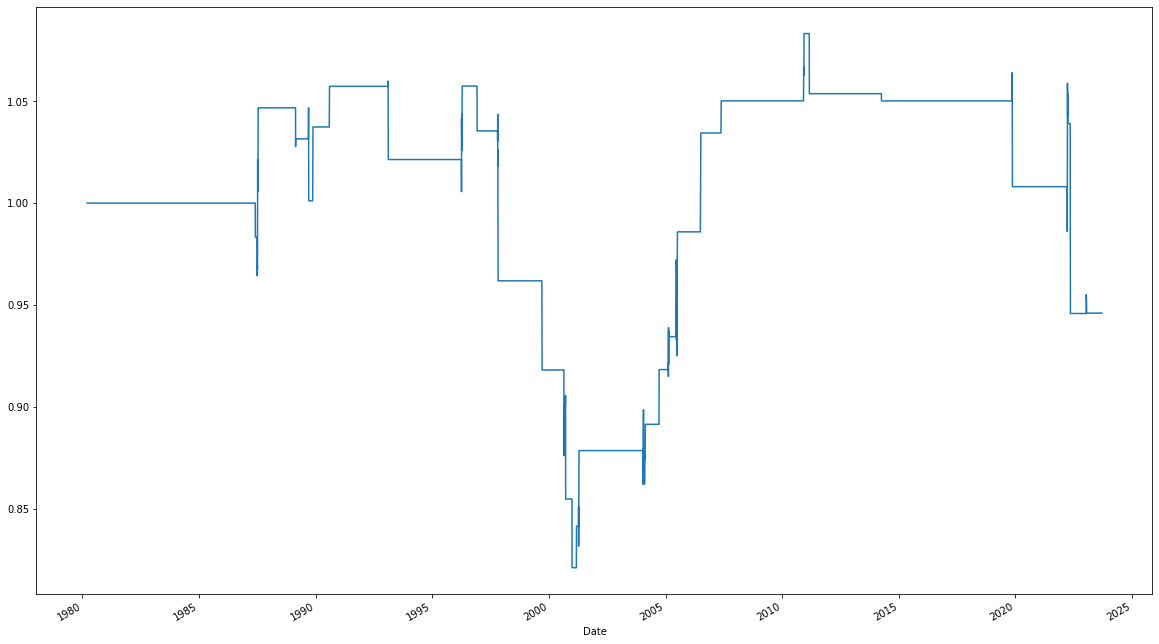

In [127]:
# df[["sReturn", "hReturn"]].plot(figsize=(20,12))
df["sReturn"].plot(figsize=(20,12))

In [125]:
# df[815:835]
# df.loc[(df["pos"] < 1) & (df["Strategy"] == -1), "Strategy"] = 0
# df["1994-01-10":"1994-02-25"]
trade = 0

date1 = (df.index[df['Strategy'] == 1].tolist()[trade] - timedelta(days=5)).strftime("%Y-%m-%d")
date2 = (df.index[df['Strategy'] == -1].tolist()[trade] + timedelta(days=5)).strftime("%Y-%m-%d")
df[date1:date2]
# date2

,Open,High,Low,Close,Volume,High52,doh,Strategy,pos,Body,SL,TP,trades,Day profit,Hold,sReturn,hReturn
Date,,,,,,,,,,,,,,,,,
1982-10-04,0.08,0.08,0.08,0.08,69328000,0.10,1982-08-16,0,0.00,0.00,NaN,NaN,0,0.00,0.01,1.00,0.65
1982-10-05,0.08,0.09,0.08,0.08,80236800,0.10,1982-08-16,0,0.00,0.00,NaN,NaN,0,0.00,0.01,1.00,0.66
1982-10-06,0.08,0.09,0.08,0.09,173532800,0.10,1982-08-16,0,0.00,0.00,NaN,NaN,0,0.00,0.07,1.00,0.70
1982-10-07,0.09,0.10,0.09,0.10,311673600,0.10,1982-08-16,0,0.00,0.00,NaN,NaN,0,0.00,0.08,1.00,0.76
1982-10-08,0.10,0.11,0.10,0.10,275542400,0.11,1982-10-08,1,0.00,0.00,0.10,0.12,1,0.00,0.07,1.00,0.82
1982-10-11,0.10,0.11,0.10,0.11,313734400,0.11,1982-10-11,0,1.00,0.00,0.10,0.12,1,0.02,0.02,1.02,0.83
1982-10-12,0.11,0.11,0.10,0.10,258944000,0.11,1982-10-11,0,1.00,0.00,0.10,0.12,1,-0.03,-0.03,0.99,0.81
1982-10-13,0.10,0.11,0.10,0.10,198844800,0.11,1982-10-11,0,1.00,0.00,0.10,0.12,1,0.01,0.01,1.00,0.82
1982-10-14,0.10,0.11,0.10,0.11,178662400,0.11,1982-10-11,0,1.00,0.00,0.10,0.12,1,0.01,0.01,1.01,0.82


In [199]:
np.exp(df["Day profit"].sum())
df[["Day profit", "Hold"]].sum().apply(np.exp) * 100

Day profit   355.62
Hold         507.81
dtype: float64

# Optimization

In [146]:
for ticker in mult_opt.columns.get_level_values(0).unique():
    print(ticker)
    display(mult_opt[ticker].sort_values("strategy return", ascending=False).head(5))

HES


,time thresh1,time thresh2,Take profit,Stop loss,strategy return,Trades,Hold return
434,24,180,1.80,0.30,1.23,20,20.75
432,24,180,1.80,0.10,1.23,20,20.75
433,24,180,1.80,0.20,1.23,20,20.75
552,24,225,1.80,0.10,1.22,22,20.75
592,24,240,1.80,0.10,1.22,22,20.75


In [119]:
mask = mult_opt["ABEO"]["time thresh1"] != 0
mult_opt["ABEO"][mask].sort_values("strategy return", ascending=False).head(20)
# mult_opt["EMO"].sort_values("strategy return", ascending=False).head(20)

,time thresh1,time thresh2,trail stop,strategy return,Trades,Hold return
34,6,280,8,109.18,37,0.00
35,6,280,9,103.82,37,0.00
31,6,260,8,101.30,36,0.00
28,6,240,8,101.30,36,0.00
29,6,240,9,98.51,36,0.00
32,6,260,9,98.51,36,0.00
25,6,220,8,87.84,35,0.00
26,6,220,9,85.42,35,0.00
22,6,200,8,83.45,34,0.00
23,6,200,9,81.15,34,0.00


C:\Users\עידן\AppData\Local\Temp\ipykernel_42532\431642830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return_mean'] = df.groupby(['time thresh1', 'time thresh2', "trail stop"])['strategy return'].transform('mean')


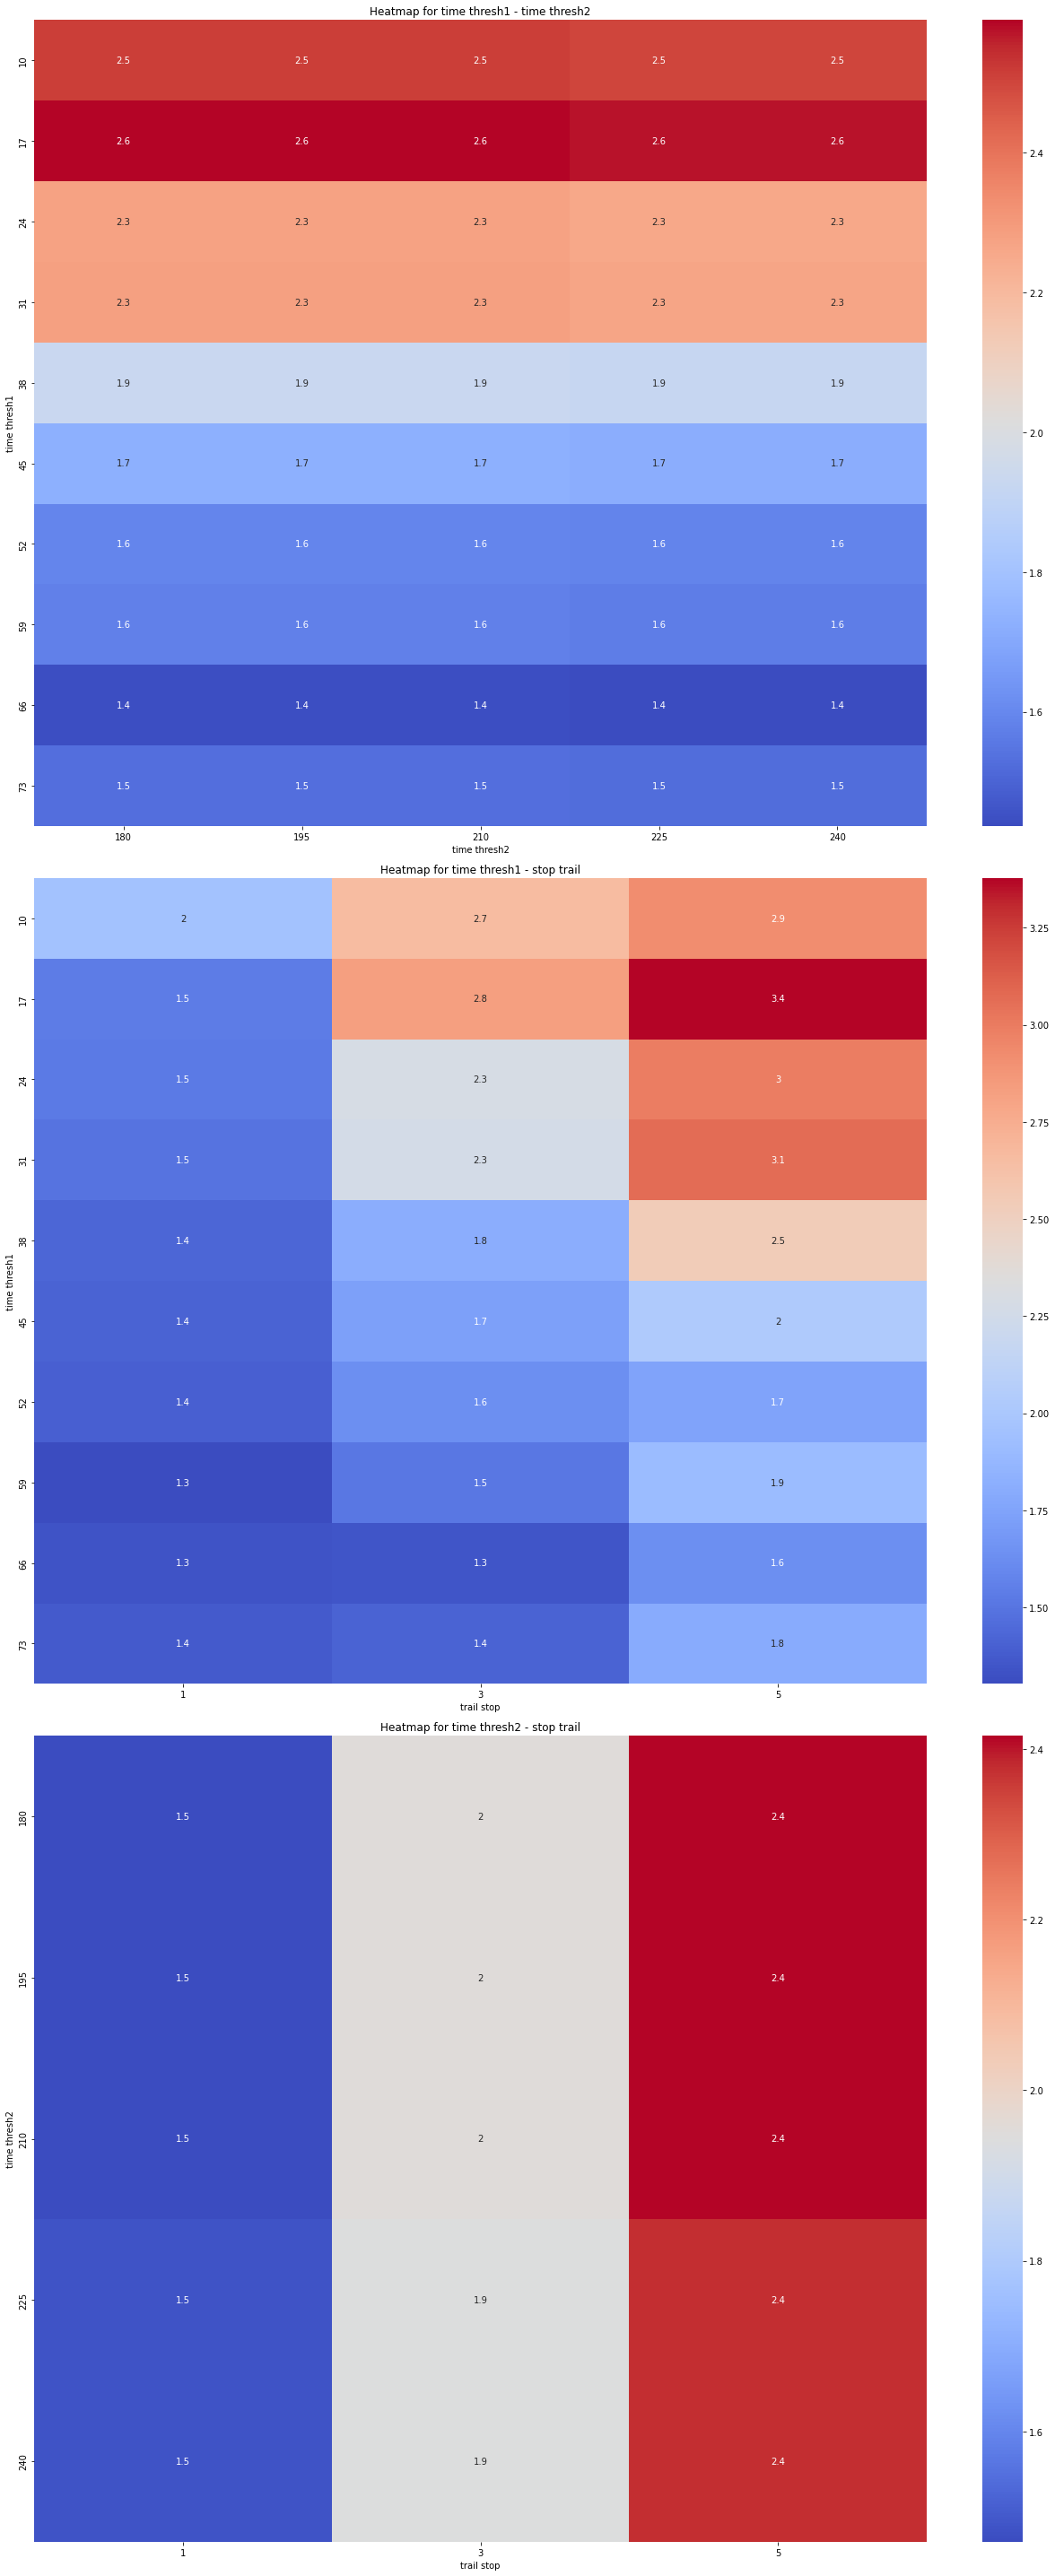

In [120]:
df = mult_opt["AAPL"]
df['return_mean'] = df.groupby(['time thresh1', 'time thresh2', "trail stop"])['strategy return'].transform('mean')
tt1_tt2 = df.pivot_table(values='return_mean', index='time thresh1', columns='time thresh2')
tt1_ts = df.pivot_table(values='return_mean', index='time thresh1', columns='trail stop')
tt2_ts = df.pivot_table(values='return_mean', index='time thresh2', columns='trail stop')

fig, ax = plt.subplots(3, 1, figsize=(18, 40))

sns.heatmap(tt1_tt2, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Heatmap for time thresh1 - time thresh2')

sns.heatmap(tt1_ts, annot=True, cmap='coolwarm', ax=ax[1])
ax[1].set_title('Heatmap for time thresh1 - stop trail')

sns.heatmap(tt2_ts, annot=True, cmap='coolwarm', ax=ax[2])
ax[2].set_title('Heatmap for time thresh2 - stop trail')

plt.tight_layout()
plt.show()

In [140]:
mult_opt.to_csv("multi.csv")

In [238]:
# pd.read_csv("multi.csv", header=[0, 1], index_col=[0]).compare(mult_opt)
# mult_opt
tmp = pd.read_csv("multi.csv", header=[0, 1], index_col=[0])

In [255]:
tmp = mult_opt.copy()

AAPL                                                           
    time thresh1 time thresh2 trail stop strategy return Trades Hold return
0             15          160          9            8.21     44    1,383.43
1             15          170          9            7.88     45    1,383.43
2             15          180          9           10.16     46    1,383.43
3             15          190          9           10.16     46    1,383.43
4             15          200          9           10.16     46    1,383.43
..           ...          ...        ...             ...    ...         ...
149           65          250          9            3.37     18    1,383.43
150           65          260          9            3.37     18    1,383.43
151           65          270          9            3.37     18    1,383.43
152           65          280          9            3.37     18    1,383.43
153           65          290          9            3.37     18    1,383.43

[154 rows x 6 columns]

In [128]:
trades_sum = pd.DataFrame(columns=["Return", "Holding days"])
all_trades = trades
for _, trade in all_trades:
    if _ == 0:
        continue
        
    trade["prev close"] = trade["Close"].shift()
    trade["Change"] = trade["Close"].pct_change() + 1
    # total_return = (trade["Cumulative Return"].iloc[-1] - 1) * 100
    trade = trade[trade["pos"] == 1].copy()
    start_price = trade.iloc[0]["prev close"]
    end_price = trade.iloc[-1]["Close"]
    holding_days = len(trade)
    
    # Clear the trade signal
    trade = trade.drop(["hReturn", "Strategy", "pos", "High52", "Hold", "prev close", "trades", "doh", "trade_high"], axis=1)
    prcnt_chng = ((end_price - start_price) / start_price) * 100
    new_row = pd.DataFrame({"Return": [prcnt_chng], "Holding days": [holding_days]})
    # new_row = pd.DataFrame({"time thresh1": [tt1], "time thresh2": [tt2], "trail stop": [trs], "strategy return": [retrn], "Trades": [trades], "Hold return": [hold_r]})
    # results = pd.concat([results, new_row], ignore_index=True)
    trades_sum = pd.concat([trades_sum, new_row], ignore_index=True)
    display(trade)
    print(prcnt_chng)
    print(holding_days)
    print("------------------------------------------------------")

KeyError: "['trade_high'] not found in axis"

In [123]:
counter = 0

succ = (trades_sum["Return"] > 0).sum()
success_rate = (succ/len(trades_sum)) * 100

avg_holding_days = trades_sum["Holding days"].mean()
print(round(success_rate, 2),"%")
print(avg_holding_days)
display(trades_sum)

51.85 %
13.567901234567902


,Return,Holding days
0,-1.06,2
1,-2.31,2
2,-1.12,2
3,3.30,5
4,-3.95,3
...,...,...
76,0.16,5
77,-1.47,8
78,-0.09,19
79,-0.67,5
